<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/data_generation_and_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing OCP pretrained models
written by S.Choung 10th Oct
This code is to test out OC models using OC pretrained models

## OCP installation

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

if not os.path.exists('ocp'):
     !git clone https://github.com/Open-Catalyst-Project/ocp.git
os.chdir('ocp')
!pip install -e .
!pip -q install  lmdb pymatgen==2023.5.10 ase==3.22.1 orjson e3nn==0.2.6 wandb
!pip install submitit

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ocp'...
remote: Enumerating objects: 11786, done.
remote: Counting objects: 100% (2674/2674), done.
remote: Compressing objects: 100% (702/702), done.
remote: Total 11786 (delta 2285), reused 2081 (delta 1972), pack-reused 9112
Receiving objects: 100% (11786/11786), 172.62 MiB | 15.90 MiB/s, done.
Resolving deltas: 100% (8138/8138), done.
Obtaining file:///content/ocp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable f

In [ ]:
import json,zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

from ase.io import read

from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from ocpmodels.datasets import SinglePointLmdbDataset
from ocpmodels.preprocessing import AtomsToGraphs
from ocpmodels.models import CGCNN,SchNet
from ocpmodels.datasets import data_list_collater
from ocpmodels.common.relaxation.ase_utils import OCPCalculator


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")


## load some useful utillities
 code taken from https://open-catalyst-project.github.io/tutorial/fine-tuning/fine-tuning-oxides.html

In [ ]:
# @title
import ocpmodels as om
from pathlib import Path

def ocp_root():
    """Return the root directory of the installed ocp package."""
    return Path(om.__file__).parent.parent

def ocp_main():
    """Return the path to ocp main.py"""
    return ocp_root() / "main.py"

In [ ]:
# @title
import subprocess
import sys
import numba
import numpy as np
import ase
import e3nn
import pymatgen.core as pc
import torch
import torch.cuda as tc
import torch_geometric as tg
import platform
import psutil

def describe_ocp():
    """Print some system information that could be useful in debugging."""
    print(sys.executable, sys.version)
    print(f'ocp is installed at {ocp_root()}')

    commit_hash = (
            subprocess.check_output(
                    [
                        "git",
                        "-C",
                        om.__path__[0],
                        "describe",
                        "--always",
                    ]
                )
                .strip()
                .decode("ascii")
            )
    print(f'ocp repo is at git commit: {commit_hash}')
    print(f'numba: {numba.__version__}')
    print(f'numpy: {np.version.version}')
    print(f'ase: {ase.__version__}')
    print(f'e3nn: {e3nn.__version__}')
    print(f'pymatgen: {pc.__version__}')
    print(f'torch: {torch.version.__version__}')
    print(f'torch.version.cuda: {torch.version.cuda}')
    print(f'torch.cuda: is_available: {tc.is_available()}')
    if tc.is_available():
        print('  __CUDNN VERSION:', torch.backends.cudnn.version())
        print('  __Number CUDA Devices:', torch.cuda.device_count())
        print('  __CUDA Device Name:',torch.cuda.get_device_name(0))
        print('  __CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)
    print(f'torch geometric: {tg.__version__}')
    print()
    print(f'Platform: {platform.platform()}')
    print(f'  Processor: {platform.processor()}')
    print(f'  Virtual memory: {psutil.virtual_memory()}')
    print(f'  Swap memory: {psutil.swap_memory()}')
    print(f'  Disk usage: {psutil.disk_usage("/")}')

In [ ]:
# @title
import urllib
import os
from pathlib import Path
import requests

checkpoints = {
    # Open Catalyst 2020 (OC20)
    'CGCNN 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_200k.pt',
    'CGCNN 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_2M.pt',
    'CGCNN 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_20M.pt',
    'CGCNN All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/cgcnn_all.pt',
    'DimeNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_200k.pt',
    'DimeNet 2M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/dimenet_2M.pt',
    'SchNet 200k'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_200k.pt',
    'SchNet 2M'	    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_2M.pt',
    'SchNet 20M'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_20M.pt',
    'SchNet All'	:'https://dl.fbaipublicfiles.com/opencatalystproject/models/2020_11/s2ef/schnet_all_large.pt',
    'DimeNet++ 200k'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_200k.pt',
    'DimeNet++ 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_2M.pt',
    'DimeNet++ 20M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_20M.pt',
    'DimeNet++ All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_02/s2ef/dimenetpp_all.pt',
    'SpinConv 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/spinconv_force_centric_2M.pt',
    'SpinConv All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/spinconv_force_centric_all.pt',
    'GemNet-dT 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_12/s2ef/gemnet_t_direct_h512_2M.pt',
    'GemNet-dT All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2021_08/s2ef/gemnet_t_direct_h512_all.pt',
    'PaiNN All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_05/s2ef/painn_h512_s2ef_all.pt',
    'GemNet-OC 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_2M.pt',
    'GemNet-OC All'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_base_s2ef_all.pt',
    'GemNet-OC All+MD'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/gemnet_oc_base_s2ef_all_md.pt',
    'GemNet-OC-Large All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_07/s2ef/gemnet_oc_large_s2ef_all_md.pt',
    'SCN 2M'   :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t1_b1_s2ef_2M.pt',
    'SCN-t4-b2 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_t4_b2_s2ef_2M.pt',
    'SCN All+MD' :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/scn_all_md_s2ef.pt',
    'eSCN-L4-M2-Lay12 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l4_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 2M'    :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_2M_s2ef.pt',
    'eSCN-L6-M2-Lay12 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m2_lay12_all_md_s2ef.pt',
    'eSCN-L6-M3-Lay20 All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_03/s2ef/escn_l6_m3_lay20_all_md_s2ef.pt',
    'EquiformerV2 (83M) 2M'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_83M_2M.pt',
    'EquiformerV2 (31M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_31M_ec4_allmd.pt',
    'EquiformerV2 (153M) All+MD'     :'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_06/oc20/s2ef/eq2_153M_ec4_allmd.pt',
    # Open Catalyst 2022 (OC22)
    'GemNet-dT OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gndt_oc22_all_s2ef.pt',
    'GemNet-OC OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_all_s2ef.pt',
    'GemNet-OC OC20+OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC trained with `enforce_max_neighbors_strictly=False` #467 OC20+OC22' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_05/oc22/s2ef/gnoc_oc22_oc20_all_s2ef.pt',
    'GemNet-OC OC20->OC22'	: 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2022_09/oc22/s2ef/gnoc_finetune_all_s2ef.pt',
    'equiformer' : 'https://dl.fbaipublicfiles.com/opencatalystproject/models/2023_10/oc22/s2ef/eq2_121M_e4_f100_oc22_s2ef.pt'
                }

def list_checkpoints():
    """List checkpoints that are available to download."""
    print('See https://github.com/Open-Catalyst-Project/ocp/blob/main/MODELS.md for more details.')
    for key in checkpoints:
        print(key)
    print('Copy one of these keys to get_checkpoint(key) to download it.')


def get_checkpoint(key):
    """Download a checkpoint.

    key: string in checkpoints.

    Returns name of checkpoint that was saved.
    """
    url = checkpoints.get(key, None)
    if url is None:
        raise Exception('No url found for {key}')

    pt = Path(urllib.parse.urlparse(url).path).name

    if not os.path.exists(pt):
        with open(pt, 'wb') as f:
            print(f'Downloading {url}')
            f.write(requests.get(url).content)
    return pt
from pathlib import Path
import numpy as np
from ase.db import connect

def train_test_val_split(ase_db, ttv=(0.8, 0.1, .1), files=('train.db', 'test.db', 'val.db'), seed=42):
    """Split an ase db into train, test and validation dbs.

    ase_db: path to an ase db containing all the data.
    ttv: a tuple containing the fraction of train, test and val data. This will be normalized.
    files: a tuple of filenames to write the splits into. An exception is raised if these exist.
           You should delete them first.
    seed: an integer for the random number generator seed

    Returns the absolute path to files.
    """

    for db in files:
        if os.path.exists(db):
            raise Exception('{db} exists. Please delete it before proceeding.')

    src = connect(ase_db)
    N = src.count()

    ttv = np.array(ttv)
    ttv /= ttv.sum()

    train_end = int(N * ttv[0])
    test_end = train_end + int(N * ttv[1])

    train = connect(files[0])
    test = connect(files[1])
    val = connect(files[2])

    ids = np.arange(1, N + 1)
    rng = np.random.default_rng(seed=42)
    rng.shuffle(ids)

    for _id in ids[0:train_end]:
        row = src.get(id=int(_id))
        train.write(row.toatoms())

    for _id in ids[train_end:test_end]:
        row = src.get(id=int(_id))
        test.write(row.toatoms())

    for _id in ids[test_end:]:
        row = src.get(id=int(_id))
        val.write(row.toatoms())

    return [Path(f).absolute() for f in files]
# @title
from yaml import load, dump
from yaml import CLoader as Loader, CDumper as Dumper
import torch
import os
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
from io import StringIO
import sys
import contextlib

def generate_yml_config(checkpoint_path, yml='run.yml', delete=(), update=()):
    """Generate a yml config file from an existing checkpoint file.

    checkpoint_path: string to path of an existing checkpoint
    yml: name of file to write to.
    pop: list of keys to remove from the config
    update: dictionary of key:values to update

    Use a dot notation in update.

    Returns an absolute path to the generated yml file.
    """

    # You can't just read in the checkpoint with torch. The calculator does some things to it.
    # Rather than recreate that here I just reuse the calculator machinery. I don't want to
    # see the output though, so I capture it.

    with contextlib.redirect_stdout(StringIO()) as _:
        config = OCPCalculator(checkpoint_path=checkpoint_path).config # there seems an parameter checkpoint changed in OCPcalculator (s.choung)

    for key in delete:
        if key in config and len(key.split('.')) == 1:
            del config[key]
        else:
            keys = key.split('.')
            if keys[0] in config:
                d = config[keys[0]]
            else:
                continue
            if isinstance(d, dict):
                for k in keys[1:]:
                    if isinstance(d[k], dict):
                        d = d[k]
                    else:
                        if k in d:
                            del d[k]

    def nested_set(dic, keys, value):
        for key in keys[:-1]:
            dic = dic.setdefault(key, {})
        dic[keys[-1]] = value

    for _key in update:
        keys = _key.split('.')
        nested_set(config, keys, update[_key])


    out = dump(config)
    with open(yml, 'wb') as f:
        f.write(out.encode('utf-8'))

    return Path(yml).absolute()

Pt/CeO2 generation


In [ ]:
gemnet = get_checkpoint('GemNet-OC OC20+OC22')
from ocpmodels.common.relaxation.ase_utils import OCPCalculator
calc = OCPCalculator(checkpoint_path=os.path.expanduser(gemnet), cpu=False)

In [ ]:
!unzip ../energy_force.zip
!unzip ../xdatcars.zip
!unzip ../contcars.zip

Archive:  ../energy_force.zip
   creating: energy_force/
  inflating: energy_force/0.dat      
  inflating: energy_force/1.dat      
  inflating: energy_force/2.dat      
  inflating: energy_force/3.dat      
  inflating: energy_force/4.dat      
  inflating: energy_force/5.dat      
  inflating: energy_force/6.dat      
  inflating: energy_force/7.dat      
  inflating: energy_force/8.dat      
  inflating: energy_force/9.dat      
  inflating: energy_force/10.dat     
  inflating: energy_force/11.dat     
  inflating: energy_force/12.dat     
  inflating: energy_force/13.dat     
  inflating: energy_force/14.dat     
  inflating: energy_force/15.dat     
  inflating: energy_force/16.dat     
  inflating: energy_force/17.dat     
  inflating: energy_force/18.dat     
  inflating: energy_force/19.dat     
  inflating: energy_force/20.dat     
  inflating: energy_force/22.dat     
  inflating: energy_force/23.dat     
  inflating: energy_force/24.dat     
  inflating: energy_force/25.da

Parsing 완료 이제 ase.db 형식으로 변환함.

In [ ]:
#!unzip ../additional.zip
!unzip outcar_traj.zip

Archive:  outcar_traj.zip
   creating: outcar_traj/
  inflating: outcar_traj/0_outcar.traj  
  inflating: outcar_traj/1_outcar.traj  
  inflating: outcar_traj/2_outcar.traj  
  inflating: outcar_traj/3_outcar.traj  
  inflating: outcar_traj/4_outcar.traj  
  inflating: outcar_traj/5_outcar.traj  
  inflating: outcar_traj/6_outcar.traj  
  inflating: outcar_traj/7_outcar.traj  
  inflating: outcar_traj/8_outcar.traj  
  inflating: outcar_traj/9_outcar.traj  
  inflating: outcar_traj/10_outcar.traj  
  inflating: outcar_traj/11_outcar.traj  
  inflating: outcar_traj/12_outcar.traj  
  inflating: outcar_traj/13_outcar.traj  
  inflating: outcar_traj/14_outcar.traj  
  inflating: outcar_traj/15_outcar.traj  
  inflating: outcar_traj/16_outcar.traj  
  inflating: outcar_traj/17_outcar.traj  
  inflating: outcar_traj/18_outcar.traj  
  inflating: outcar_traj/19_outcar.traj  
  inflating: outcar_traj/20_outcar.traj  
  inflating: outcar_traj/21_outcar.traj  
  inflating: outcar_traj/22_outcar

## additional CeO2 data

### there is some issue to parse OUTCAR of VASP6 so i just did it in local and bring it back. as .traj

In [ ]:
'''
import os
import re
from ase.io.vasp import read_vasp_xdatcar, read_vasp

# Get the current working directory
folder_path = os.getcwd()

xdatcar_path = os.path.join(folder_path, 'additional/add_xdatcars')
add_xdatcars = [f for f in os.listdir(xdatcar_path) if f.endswith('_XDATCAR')]
traj_num = len(add_xdatcars)
print(traj_num)

contcar_path = os.path.join(folder_path, 'additional/add_contcars')
contcars = [f for f in os.listdir(contcar_path) if f.endswith('_CONTCAR') ]

add_contcar_ase_list=[]
for contcar in contcars:
  aseatoms = read_vasp(f"{contcar_path}/{contcar}")
  add_contcar_ase_list.append(aseatoms)

energy_force_folder = os.path.join(folder_path, 'additional/add_energy_force')

# Check if energy_force_folder exists
if os.path.exists(energy_force_folder) and os.path.isdir(energy_force_folder):
    add_data = {}  # Use a dictionary to store data for different .dat files
    for filename in os.listdir(energy_force_folder):
        if filename.endswith('.dat'):
            # Skip files with names '11.dat' or '8.dat'
            if filename in ['11.dat', '8.dat']:
                continue

            file_path = os.path.join(energy_force_folder, filename)
            file_data = []  # List to store data for the current file
            with open(file_path, 'r') as f:
                for line in f:
                    match = re.match(r'^\s*(\d+)\s+(\S+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)', line)
                    if match:
                        iteration, force, energy, _ = match.groups()
                        file_data.append((int(iteration), float(force), float(energy)))
            # Store the data for the current file in the dictionary
            add_data[filename[:-4]] = file_data  # Remove the .dat extension from the filename

    print('Parsed data (iteration, force, energy) for each file:')
    for filename, file_data in add_data.items():
        print(f'File: {filename}')
        for d in file_data:
            print(d)
else:
    print(f"'{energy_force_folder}' does not exist or is not a directory.")


count=0
for filename, file_data in add_data.items():
    #print(f'File: {filename}')
    for d in file_data:
        #print(d)
        count= count+1
print(count)
'''

'\nimport os\nimport re\nfrom ase.io.vasp import read_vasp_xdatcar, read_vasp\n\n# Get the current working directory\nfolder_path = os.getcwd()\n\nxdatcar_path = os.path.join(folder_path, \'additional/add_xdatcars\')\nadd_xdatcars = [f for f in os.listdir(xdatcar_path) if f.endswith(\'_XDATCAR\')]\ntraj_num = len(add_xdatcars)\nprint(traj_num)\n\ncontcar_path = os.path.join(folder_path, \'additional/add_contcars\')\ncontcars = [f for f in os.listdir(contcar_path) if f.endswith(\'_CONTCAR\') ]\n\nadd_contcar_ase_list=[]\nfor contcar in contcars:\n  aseatoms = read_vasp(f"{contcar_path}/{contcar}")\n  add_contcar_ase_list.append(aseatoms)\n\nenergy_force_folder = os.path.join(folder_path, \'additional/add_energy_force\')\n\n# Check if energy_force_folder exists\nif os.path.exists(energy_force_folder) and os.path.isdir(energy_force_folder):\n    add_data = {}  # Use a dictionary to store data for different .dat files\n    for filename in os.listdir(energy_force_folder):\n        if filena

In [ ]:
from ase.io import Trajectory

# Define a function to get the order number from a filename
def get_order_number(filename):
    match = re.search(r'(\d+)_XDATCAR', filename)
    if match:
        return int(match.group(1))
    return None
# Get the current working directory
outcar_asetraj_list=[]
folder_path = os.getcwd()
outcar_path = os.path.join(folder_path, 'outcar_traj')

outcars = sorted(
    [f for f in os.listdir(outcar_path) if f.endswith('traj') and not any(exclude in f for exclude in ['8_outcar.traj', '11_outcar.traj', '21_outcar.traj'])],
    key=lambda filename: xdatcars.index(filename.replace('_outcar.traj', '_XDATCAR'))
)

for f in outcars:
   print(f)
   path=os.path.join(outcar_path, f)
   out_traj=Trajectory(path)
   outcar_asetraj_list.append(out_traj)


0_outcar.traj
1_outcar.traj
2_outcar.traj
3_outcar.traj
4_outcar.traj
5_outcar.traj
6_outcar.traj
7_outcar.traj
9_outcar.traj
10_outcar.traj
12_outcar.traj
13_outcar.traj
14_outcar.traj
15_outcar.traj
16_outcar.traj
17_outcar.traj
19_outcar.traj
20_outcar.traj
22_outcar.traj
23_outcar.traj
24_outcar.traj


In [ ]:
import os
import re
from ase.io.vasp import read_vasp_xdatcar, read_vasp

# Define a function to get the order number from a filename
def get_order_number(filename):
    match = re.search(r'(\d+)_XDATCAR', filename)
    if match:
        return int(match.group(1))
    return None
# Get the current working directory
folder_path = os.getcwd()

xdatcar_path = os.path.join(folder_path, 'xdatcars2')
contcar_path = os.path.join(folder_path, 'contcars2')
energy_force_folder = os.path.join(folder_path, 'energy_force')

xdatcars = [f for f in os.listdir(xdatcar_path) if f.endswith('_XDATCAR') and not any(exclude in f for exclude in ['8_XDATCAR', '11_XDATCAR', '21_XDATCAR'])]
xdatcars.sort(key=get_order_number)
contcars = sorted(
    [f for f in os.listdir(contcar_path) if f.endswith('_CONTCAR') and not any(exclude in f for exclude in ['8_CONTCAR', '11_CONTCAR', '21_XDATCAR'])],
    key=lambda filename: xdatcars.index(filename.replace('_CONTCAR', '_XDATCAR'))
)
print(xdatcars)
print(contcars)
# Check if the number of XDATCAR and CONTCAR files match
if len(xdatcars) != len(contcars):
    print("Error: The number of XDATCAR and CONTCAR files does not match.")
else:
    traj_num = len(xdatcars)
    print(f"Total trajectories: {traj_num}")

    contcar_ase_list = []
    xdatcar_asetraj_list = []

    for xdatcar, contcar in zip(xdatcars, contcars):
        # Read CONTCAR and append to contcar_ase_list
        contcar_atoms = read_vasp(os.path.join(contcar_path, contcar))
        contcar_ase_list.append(contcar_atoms)

        # Read XDATCAR and append to xdatcar_asetraj_list
        xdatcar_frames = read_vasp_xdatcar(os.path.join(xdatcar_path, xdatcar), index=slice(1, None))
        xdatcar_asetraj_list.append(xdatcar_frames)

energy_force_files = [    f for f in os.listdir(energy_force_folder)     if f.endswith('.dat') and re.match(r'^\d+\.dat', f)]
energy_force_files = sorted(
    [f for f in os.listdir(energy_force_folder) if f.endswith('.dat') and not any(exclude in f for exclude in ['8.dat', '11.dat', '21.dat'])],
    key=lambda filename: xdatcars.index(filename.replace('.dat','_XDATCAR'))
)

print(energy_force_files)
print(len(energy_force_files))

data = {}  # Use a dictionary to store data for different .dat files
for filename in energy_force_files:
    file_path = os.path.join(energy_force_folder, filename)
    file_data = []  # List to store data for the current file
    with open(file_path, 'r') as f:
        for line in f:
            match = re.match(r'^\s*(\d+)\s+(\S+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)', line)
            if match:
                iteration, force, energy, _ = match.groups()
                file_data.append((int(iteration), float(force), float(energy)))
    # Store the data for the current file in the dictionary
    data[filename[:-4]] = file_data  # Remove the .dat extension from the filename

print('Parsed data (iteration, force, energy) for each file:')
'''
for filename, file_data in data.items():
    print(f'File: {filename}')
    for d in file_data:
        print(d)
'''
count=0
for filename, file_data in data.items():
    #print(f'File: {filename}')
    for d in file_data:
        #print(d)
        count= count+1
print(count)

['0_XDATCAR', '1_XDATCAR', '2_XDATCAR', '3_XDATCAR', '4_XDATCAR', '5_XDATCAR', '6_XDATCAR', '7_XDATCAR', '9_XDATCAR', '10_XDATCAR', '12_XDATCAR', '13_XDATCAR', '14_XDATCAR', '15_XDATCAR', '16_XDATCAR', '17_XDATCAR', '19_XDATCAR', '20_XDATCAR', '22_XDATCAR', '23_XDATCAR', '24_XDATCAR', '25_XDATCAR', '26_XDATCAR', '27_XDATCAR', '29_XDATCAR']
['0_CONTCAR', '1_CONTCAR', '2_CONTCAR', '3_CONTCAR', '4_CONTCAR', '5_CONTCAR', '6_CONTCAR', '7_CONTCAR', '9_CONTCAR', '10_CONTCAR', '12_CONTCAR', '13_CONTCAR', '14_CONTCAR', '15_CONTCAR', '16_CONTCAR', '17_CONTCAR', '19_CONTCAR', '20_CONTCAR', '22_CONTCAR', '23_CONTCAR', '24_CONTCAR', '25_CONTCAR', '26_CONTCAR', '27_CONTCAR', '29_CONTCAR']
Total trajectories: 25
['0.dat', '1.dat', '2.dat', '3.dat', '4.dat', '5.dat', '6.dat', '7.dat', '9.dat', '10.dat', '12.dat', '13.dat', '14.dat', '15.dat', '16.dat', '17.dat', '19.dat', '20.dat', '22.dat', '23.dat', '24.dat', '25.dat', '26.dat', '27.dat', '29.dat']
25
Parsed data (iteration, force, energy) for each 

In [ ]:
from ase.io import Trajectory
from ase.io.vasp import read_vasp_xdatcar

xdatcar_constrainted_asetraj_list=[]

force_list=[]
energy_list=[]

for contcar_atoms, xdatcar_asetraj, file_data in zip(contcar_ase_list, xdatcar_asetraj_list, data.values()):
    # Extract separate columns from file_data
    iterations = [data[0] for data in file_data]
    forces = [data[1] for data in file_data]
    force_list.append(forces)
    energies = [data[2] for data in file_data]
    energy_list.append(energies)

    print("identify cont and xdat str matches:", len(contcar_atoms), len(xdatcar_asetraj[0]))
    print("identify xdat and ef order match:", len(xdatcar_asetraj), len(forces))

    for i, atoms in enumerate(xdatcar_asetraj):
        # Apply constraints from contcar_atoms to atoms
        atoms.set_constraint(contcar_atoms.constraints)

    xdatcar_constrainted_asetraj_list.append(xdatcar_asetraj)


identify cont and xdat str matches: 48 48
identify xdat and ef order match: 24 24


In [ ]:
from ase.db import connect
from ase.calculators.singlepoint import SinglePointCalculator
from ase import Atoms

# Remove the existing database
! rm -fr pt_ceo2.db

db = connect('pt_ceo2.db')

for i, aseatoms_list in enumerate(xdatcar_constrainted_asetraj_list):
    for j, ase_atoms in enumerate(aseatoms_list):
        print(ase_atoms)
        atoms = ase_atoms.copy()
        calc = SinglePointCalculator(atoms,
                                     energy=outcar_asetraj_list[i][j].get_total_energy(),
                                     forces=outcar_asetraj_list[i][j].get_forces())
        atoms.set_calculator(calc)
        atoms.set_tags(np.ones(len(atoms)))

        print(atoms)
        db.write(atoms)


Atoms(symbols='Ce16O32', pbc=True, cell=[[7.754604, 0.0, 0.0], [-3.877302, 6.715684, 0.0], [0.0, 0.0, 27.0]], constraint=FixAtoms(indices=[0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]))
Atoms(symbols='Ce16O32', pbc=True, cell=[[7.754604, 0.0, 0.0], [-3.877302, 6.715684, 0.0], [0.0, 0.0, 27.0]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), calculator=SinglePointCalculator(...))
Atoms(symbols='Ce16O32', pbc=True, cell=[[7.754604, 0.0, 0.0], [-3.877302, 6.715684, 0.0], [0.0, 0.0, 27.0]], constraint=FixAtoms(indices=[0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]))
Atoms(symbols='Ce16O32', pbc=True, cell=[[7.754604, 0.0, 0.0], [-3.877302, 6.715684, 0.0], [0.0, 0.0, 27.0]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]), calculator=SinglePointCalculator(...))
Atoms(symbols='Ce16O32', pbc=True, cell=[[7.754604, 0.0, 0.0], [-3.877302, 6.715684, 0.0], [0.0, 0

In [ ]:
! ase db pt_ceo2.db

id|age|formula|calculator|  energy|natoms| fmax|pbc|  volume|charge|    mass
 1| 8s|Ce16O32|unknown   |-388.260|    48|0.143|TTT|1406.092| 0.000|2753.824
 2| 8s|Ce16O32|unknown   |-388.261|    48|0.156|TTT|1406.092| 0.000|2753.824
 3| 8s|Ce16O32|unknown   |-388.262|    48|0.182|TTT|1406.092| 0.000|2753.824
 4| 8s|Ce16O32|unknown   |-388.273|    48|0.154|TTT|1406.092| 0.000|2753.824
 5| 8s|Ce16O32|unknown   |-388.282|    48|0.142|TTT|1406.092| 0.000|2753.824
 6| 8s|Ce16O32|unknown   |-388.292|    48|0.136|TTT|1406.092| 0.000|2753.824
 7| 8s|Ce16O32|unknown   |-388.295|    48|0.224|TTT|1406.092| 0.000|2753.824
 8| 8s|Ce16O32|unknown   |-388.296|    48|0.191|TTT|1406.092| 0.000|2753.824
 9| 8s|Ce16O32|unknown   |-388.302|    48|0.112|TTT|1406.092| 0.000|2753.824
10| 8s|Ce16O32|unknown   |-388.309|    48|0.151|TTT|1406.092| 0.000|2753.824
11| 8s|Ce16O32|unknown   |-388.315|    48|0.139|TTT|1406.092| 0.000|2753.824
12| 8s|Ce16O32|unknown   |-388.325|    48|0.092|TTT|1406.092| 0.000|2753.824

In [ ]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy
import ase.io
import ase.calculators.singlepoint


import locale
locale.getpreferredencoding = lambda: "UTF-8"
if not os.path.exists('tutorial'):
     !git clone https://github.com/Open-Catalyst-Project/tutorial.git
GemNet_checkpoint = get_checkpoint('GemNet-OC OC20+OC22')


Cloning into 'tutorial'...
remote: Enumerating objects: 2147, done.
remote: Counting objects: 100% (1408/1408), done.
remote: Compressing objects: 100% (1134/1134), done.
remote: Total 2147 (delta 311), reused 1328 (delta 249), pack-reused 739
Receiving objects: 100% (2147/2147), 29.67 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (560/560), done.


In [ ]:
! rm -fr train.db test.db val.db
train, test, val = train_test_val_split('pt_ceo2.db')
train, test, val

(PosixPath('/content/ocp/train.db'),
 PosixPath('/content/ocp/test.db'),
 PosixPath('/content/ocp/val.db'))

In [ ]:
import time
import subprocess
import os

def train_and_save_checkpoint(lr, epochs, checkpoint_name):
    # Generate the YAML configuration with the specified LR and epochs
    yml = generate_yml_config(GemNet_checkpoint, 'config.yml',
               delete=['slurm', 'cmd', 'logger', 'task', 'model_attributes',
                       'optim.loss_force',
                       'dataset', 'test_dataset', 'val_dataset'],
               update={'gpus': 1,
                       'task.dataset': 'ase_db',
                       'optim.eval_every': 1,
                       'optim.max_epochs': epochs,
                       'lr_initial': lr,
                       'dataset.train.src': 'train.db',
                       'dataset.train.a2g_args.r_energy': True,
                       'dataset.train.a2g_args.r_forces': True,
                       'dataset.test.src': 'test.db',
                       'dataset.test.a2g_args.r_energy': False,
                       'dataset.test.a2g_args.r_forces': False,
                       'dataset.val.src': 'val.db',
                       'dataset.val.a2g_args.r_energy': True,
                       'dataset.val.a2g_args.r_forces': True,
                      })

    # Construct the shell command
    shell_command = f'python main.py --mode train --config-yml "{yml}" --checkpoint "{GemNet_checkpoint}" --run-dir fine-tuning --identifier {checkpoint_name} --amp > train_info/{checkpoint_name}.txt 2>&1'

    # Measure execution time
    t0 = time.time()
    subprocess.run(shell_command, shell=True)
    elapsed_time = time.time() - t0

    print(f'Training completed. Elapsed time = {elapsed_time:1.1f} seconds')

    return checkpoint_name  # Return the checkpoint name

def save_checkpoint(checkpoint_name):
    # Save the checkpoint to the specified directory
    save_checkpoint_path = os.path.join("/content/drive/MyDrive/check_points/pt_ceo2", checkpoint_name)
    os.makedirs(save_checkpoint_path, exist_ok=True)
    subprocess.run(f'cp -r fine-tuning/checkpoint {save_checkpoint_path}', shell=True)
    print(f'Checkpoint saved to {save_checkpoint_path}')

# Example usage:
learning_rates = [0.00005,0.000005]  # List of learning rates to try
epochs_list = [100, 200]  # List of epochs to try

for lr in learning_rates:
    for epochs in epochs_list:
        checkpoint_name = f"lr_{lr}_epochs_{epochs}"
        trained_checkpoint = train_and_save_checkpoint(lr, epochs, checkpoint_name)
        #save_checkpoint(trained_checkpoint)  # Save the checkpoint after training


Training completed. Elapsed time = 542.9 seconds


Training completed. Elapsed time = 1087.4 seconds


Training completed. Elapsed time = 550.6 seconds
Training completed. Elapsed time = 1099.4 seconds


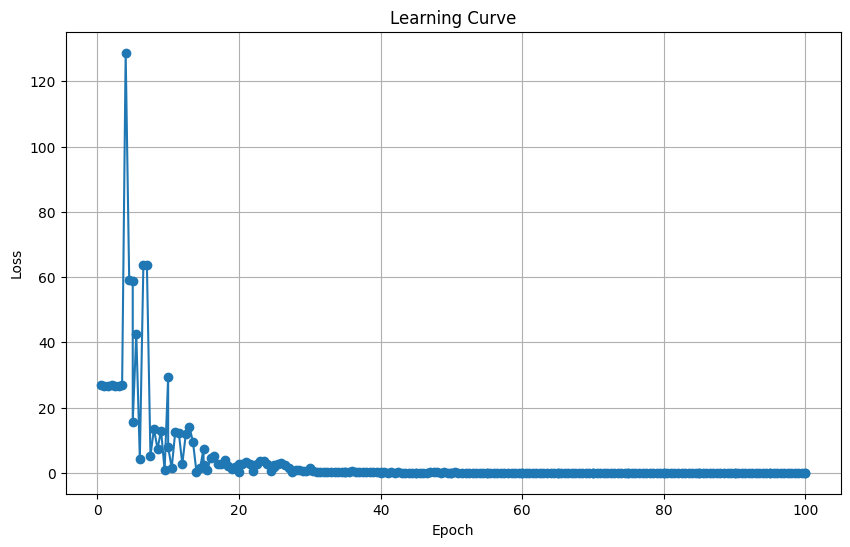

In [ ]:
import matplotlib.pyplot as plt

# Define the path to the train.txt file
train_log_path = '/content/ocp/train_info/lr_5e-06_epochs_100.txt'  # Update this with the correct path

# Lists to store epoch and metric values
epochs = []
loss_values = []

# Read and parse the train.txt file
with open(train_log_path, 'r') as log_file:
    lines = log_file.readlines()
    for line in lines:
        # Check if the line contains relevant training information
        if 'loss:' in line:
            parts = line.split(',')
            for part in parts:
                if 'epoch:' in part:
                    epoch = float(part.split(':')[-1])
                    epochs.append(epoch)
                elif 'loss:' in part:
                    loss = float(part.split(':')[1])
                    loss_values.append(loss)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-')
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
yml = generate_yml_config(GemNet_checkpoint, 'config.yml',
                   delete=['slurm', 'cmd', 'logger', 'task', 'model_attributes',
                           'optim.loss_force', # the checkpoint setting causes an error
                           'dataset', 'test_dataset', 'val_dataset'],
                   update={'gpus': 1,
                           'task.dataset': 'ase_db',
                           'optim.eval_every': 1,
                           'optim.max_epochs': 10,
                           'lr_initial': 0.00005, # 1/10 of original one
                           # Train data
                           'dataset.train.src': 'train.db',
                           'dataset.train.a2g_args.r_energy': True,
                           'dataset.train.a2g_args.r_forces': True,
                            # Test data - prediction only so no regression
                           'dataset.test.src': 'test.db',
                           'dataset.test.a2g_args.r_energy': False,
                           'dataset.test.a2g_args.r_forces': False,
                           # val data
                           'dataset.val.src': 'val.db',
                           'dataset.val.a2g_args.r_energy': True,
                           'dataset.val.a2g_args.r_forces': True,
                          })
import time
import subprocess

# Define the paths to the YAML configuration file and checkpoint

# Construct the shell command
shell_command = f'python main.py --mode train --config-yml "{yml}" --checkpoint "{GemNet_checkpoint}" --run-dir fine-tuning --identifier ft-oxides --amp > train.txt 2>&1'

# Measure execution time
t0 = time.time()
subprocess.run(shell_command, shell=True)
elapsed_time = time.time() - t0

print(f'Elapsed time = {elapsed_time:1.1f} seconds')


In [ ]:
cpline = !grep "checkpoint_dir:" train.txt
cpdir = cpline[0].split(':')[-1].strip()
cpdir

'fine-tuning/checkpoints/2023-11-10-08-14-56-ft-oxides'

In [ ]:
!cp -r /content/ocp/fine-tuning  /content/drive/MyDrive/check_points/pt_ceo2/

위까지, Pt/CeO2 모델 오나성. 일단 nuria모델이용해서 테스트해보고, Screening용 vacacny모델은 Unvailinging쓰면 될듯?

In [ ]:
from ase import Atoms
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS, FIRE
import numpy as np
import pandas as pd
import requests
import pprint
import sys
import string
import json
import io
import copy
import ase.io
import ase.calculators.singlepoint
from ase.optimize import LBFGS
from ase.build import fcc111, molecule, add_adsorbate
from ase.constraints import ExpCellFilter, StrainFilter


def energy_cal(atoms, fmax=0.05):
    atoms.set_calculator(calc)
    tags = np.ones(len(atoms))
    atoms.set_tags(tags)
    print(tags)
    opt1 = LBFGS(atoms)
    opt1.run(fmax=fmax,steps=300)
    return atoms.get_total_energy()
def status(proceed):
    num = int(proceed/5)
    return '🟩'*num+'⬜️'*(20-num)
def oc_calculator(data, fmax_ref, calculator):
    E_tot_list=[]
    for i, d in enumerate(data):
        print('<<<<<<<<<<<<<<<<<<<<<<<<<<<<<', i+1, ' out of ', len(data), '>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
        E_tot = energy_cal(d, fmax=fmax_ref)
        E_tot_list.append(round(E_tot, 3))
        proceed = round((i+1) / len(data) * 100, 2)
        print(status(proceed), proceed, '% done')
    return E_tot_list

e_adslab_tot=oc_calculator(adslab_list,0.05,calc)
e_slab_tot=oc_calculator(slab_list,0.05,calc)

In [ ]:
import json

json_file_path = "adslab_energylist_output.json"  # Replace with the desired file path
json_file_path2 = "slab_energylist_output.json"  # Replace with the desired file path

# Write the list to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(e_adslab_tot, json_file)
# Write the list to the JSON file
with open(json_file_path2, "w") as json_file:
    json.dump(e_slab_tot, json_file)

In [ ]:
from ase.io import Trajectory, write

write('./adslab_list_relaxed.traj',adslab_list)
write('./slab_list_relaxed.traj',slab_list)

!cp -r './adslab_list_relaxed.traj' /content/drive/MyDrive/sa_generation_1029
!cp -r './slab_list_relaxed.traj' /content/drive/MyDrive/sa_generation_1029


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Your data - stat_tot_e and e_tot should be lists or arrays
# benchmark should be a string with the benchmark name

# Create the scatter plot
plt.scatter(stat_tot_e, e_tot, color='black')

# Set the title and axis labels
plt.title('#' + benchmark + ' benchmark')
plt.xlabel('E_tot E_OC_model(eV)')
plt.ylabel('E_tot E_PBE(eV)')

# Optionally, you can add a grid
plt.grid(True)

# Calculate MAE and RMSE
mae = mean_absolute_error(e_tot, stat_tot_e)
rmse = np.sqrt(mean_squared_error(e_tot, stat_tot_e))

# Print MAE and RMSE
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Show the plot
plt.show()
